In [1]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        assert run.summary["count"] == dict(squad=1000, cnn_dailymail=500)[task]
        mc = run.summary["model_config"] if "model_config" in run.summary else {}
        sparsity = copy.deepcopy(run.config["sparsity"])
        if "score" in sparsity:
            score = sparsity.pop("score")
            sparsity["ann_score"] = score.pop("name")
            sparsity.update(score)
        return dict(
            task=task,
            model_scale=run.config["model"].replace("EleutherAI/pythia-", ""),
            **sparsity,
            n_heads=mc["num_attention_heads"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            prefill_length=run.summary["prefill_length"],
            match=run.summary.get("match"),
            rougeL=run.summary.get("rougeL"),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"] * s["n_heads"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"] * s["n_heads"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"] * s["n_heads"]
        # read/write scores
        index_elements = 1 + 2 * s["prefill_length"]

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"] * s["n_heads"]
        # write index
        index_elements += dict(low_rank=s["rank"], sparse_q=s["head_size"])[s["ann_score"]] * s["n_heads"]
        # read index
        index_elements += s["prefill_length"] * s["rank"] * s["n_heads"]

    else:
        assert False, s["name"]

    return count_kv * kv_elements + count_index * index_elements

def technique(s: pd.Series) -> str:
    return "_".join(str(n) for n in [s["name"], s["strategy"], s["ann_score"]] if not pd.isna(n))

df = (
    load_sweep("RMOE-56-baselines")
    .pipe(lambda d: d.assign(score=d.match.where(~d.match.isna(), d.rougeL)))
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d.assign(index_transfers=d.apply(partial(memory_transfers_attention_only, count_kv=False), axis=1)))
    .pipe(lambda d: d.assign(technique=d.apply(technique, axis=1)))
    .drop(columns=["add_avg", "apply_after_softmax", "n_heads", "head_size", "prefill_length", "match", "rougeL"])
)
df.head()

,task,model_scale,k,name,local_k,ann_score,rank,strategy,score,transfers,index_transfers,technique
0,cnn_dailymail,6.9b,64.0,ann,16.0,sparse_q,32.0,NaN,0.204543,1769687.04,1237207.04,ann_sparse_q
1,cnn_dailymail,6.9b,64.0,ann,16.0,sparse_q,16.0,NaN,0.204858,1153131.52,620651.52,ann_sparse_q
2,cnn_dailymail,6.9b,64.0,ann,16.0,sparse_q,8.0,NaN,0.193703,844853.76,312373.76,ann_sparse_q
3,cnn_dailymail,6.9b,32.0,ann,8.0,sparse_q,64.0,NaN,0.207471,2740654.08,2470318.08,ann_sparse_q
4,cnn_dailymail,6.9b,32.0,ann,8.0,sparse_q,32.0,NaN,0.203636,1507543.04,1237207.04,ann_sparse_q


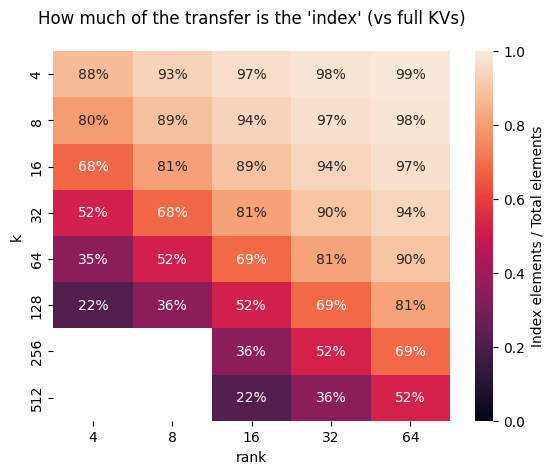

In [3]:
d = (df[(df.model_scale=="2.8b")&(df.ann_score=="sparse_q")&(df.task=="squad")]
     .pipe(lambda d: d.assign(rank=d["rank"].astype("long"), k=d["k"].astype("long")))
     .pipe(lambda d: d.assign(index_ratio=d.index_transfers/d.transfers)).pivot(index="k", columns="rank", values="index_ratio")
)
sns.heatmap(d, vmin=0, vmax=1, annot=True, fmt=".0%", cbar_kws=dict(label="Index elements / Total elements"))
plt.title("How much of the transfer is the 'index' (vs full KVs)", pad=20);

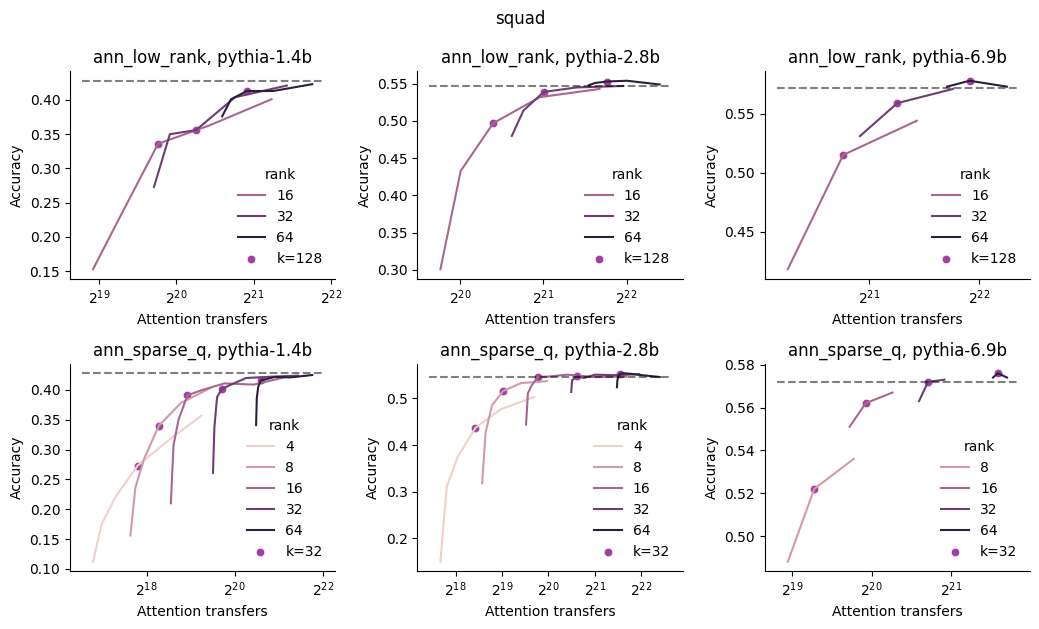

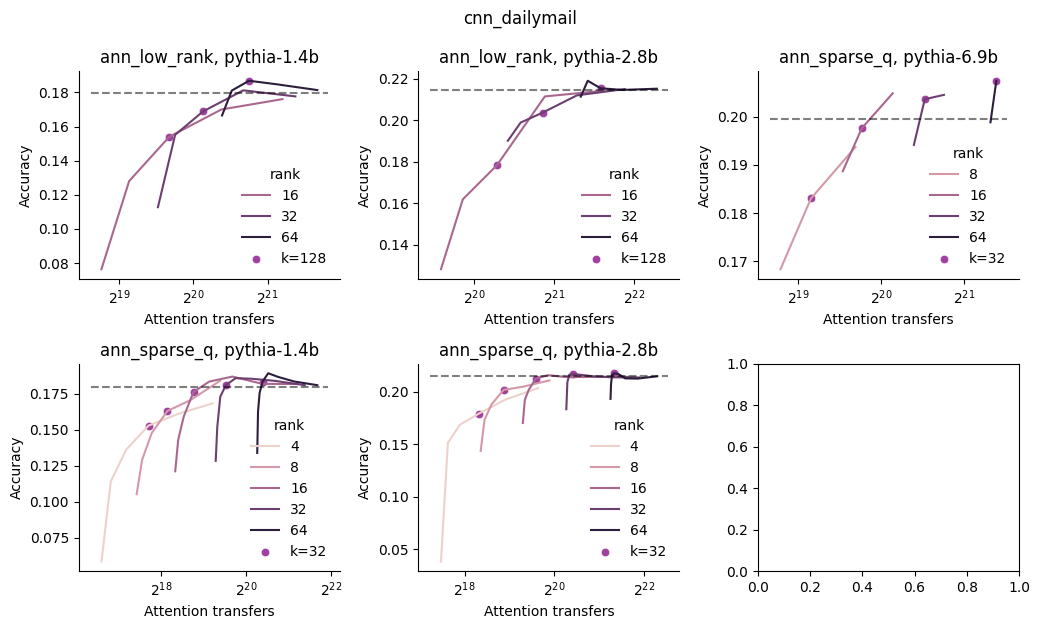

In [20]:
for task in ["squad", "cnn_dailymail"]:
    model_scales = ["1.4b", "2.8b", "6.9b"]

    _, axs = plt.subplots(2, len(model_scales), figsize=(3.5 * len(model_scales), 6))
    for axr, model_scale in zip(axs.T, model_scales):
        d = df.pipe(lambda d: d[d.name == "ann"]).pipe(lambda d: d.assign(rank=d["rank"].astype("long"), k=d["k"].astype("long"))).pipe(lambda d: d[d.task == task]).pipe(lambda d: d[d.model_scale == model_scale])
        for ax, (technique, g) in zip(axr, d.groupby("technique")):
            best_k = dict(ann_low_rank=128, ann_sparse_q=32)[technique]
            sns.lineplot(data=g, y="score", x="transfers", hue="rank", hue_norm=matplotlib.colors.LogNorm(vmin=4, vmax=64), ax=ax)
            sns.scatterplot(data=g[g.k == best_k], y="score", x="transfers", color="purple", label=f"k={best_k}", alpha=.75, ax=ax)
            ax.set_xscale("log", base=2)
            ax.hlines(df.score[(df.task==task)&(df.model_scale==model_scale)&(df.technique=="dense")].item(), *ax.get_xlim(), color="k", linestyles="--", alpha=.5)
            ax.legend(loc="lower right", title=f"rank", frameon=False)
            ax.set_title(f"{technique}, pythia-{model_scale}")
            ax.set_ylabel("Accuracy")
            ax.set_xlabel("Attention transfers")
            sns.despine(ax=ax)
    plt.tight_layout()
    plt.suptitle(task, y=1.04)

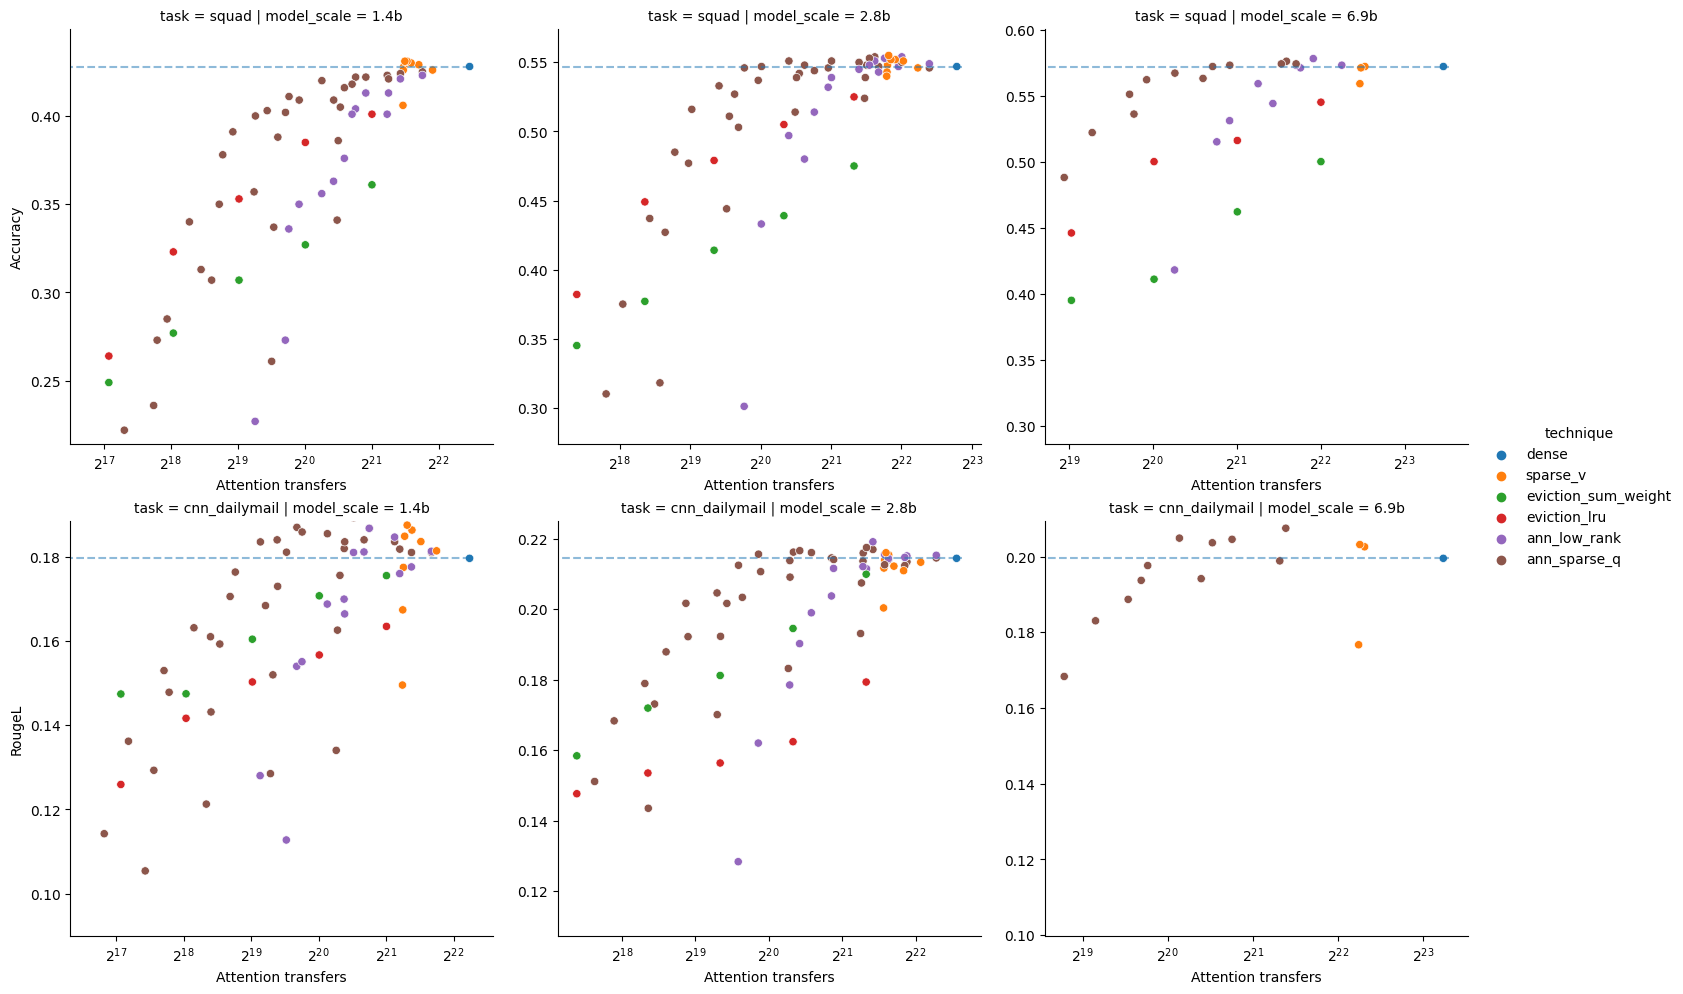

In [5]:
g = sns.relplot(data=df, y="score", x="transfers",
                hue="technique", hue_order=["dense", "sparse_v", "eviction_sum_weight", "eviction_lru", "ann_low_rank", "ann_sparse_q"],
                row="task", row_order=["squad", "cnn_dailymail"],
                col="model_scale", col_order=["1.4b", "2.8b", "6.9b"],
                facet_kws=dict(sharex=False, sharey=False))

for (task, model_scale), ax in g.axes_dict.items():
    d = df[(df.task==task)&(df.model_scale==model_scale)&(df.technique=="dense")]
    if len(d):
        baseline = d.score.item()
        ax.hlines([baseline], *ax.get_xlim(), sns.color_palette()[0], linestyles="--", alpha=.5)
        ax.set_ylim((baseline*.5, baseline*1.05))
        ax.set_xscale("log", base=2)
        ax.set_xlabel("Attention transfers")
        if model_scale == "1.4b":
            ax.set_ylabel(dict(squad="Accuracy", cnn_dailymail="RougeL")[task])

# Rough "main results" ideas...

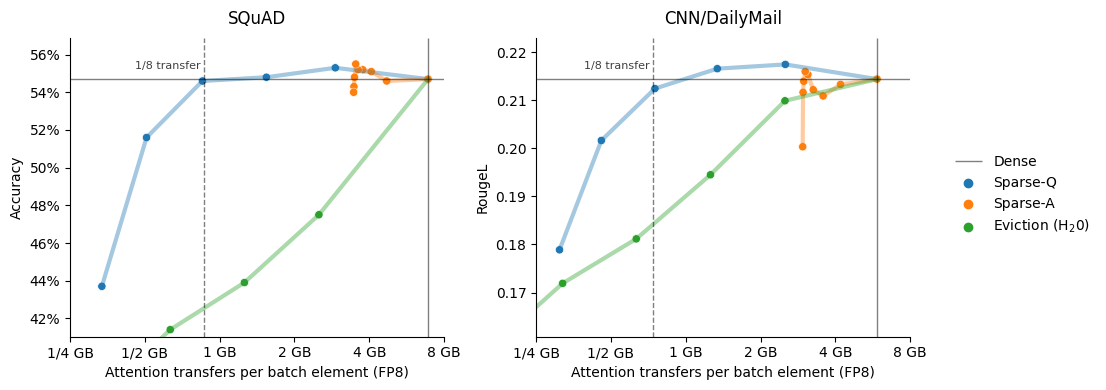

In [32]:
def add_dense_as_sparse_technique(df: pd.DataFrame) -> pd.DataFrame:
    """Add 'dense' as if it were a sparse technique.
    Note that this only gives it the sparse 'technique' string.
    """
    def _map(g: pd.DataFrame) -> pd.DataFrame:
        g_dense = g[g.technique=="dense"]
        assert len(g_dense) == 1
        return (g.groupby("technique")
                .apply(lambda gg: gg if gg.name=="dense" else pd.concat([gg, g_dense.assign(technique=gg.name)]))
                .reset_index(drop=True))
    return df.groupby(["task", "model_scale"]).apply(_map).reset_index(drop=True)

techniques = dict(dense="Dense", ann_sparse_q="Sparse-Q", sparse_v="Sparse-A", eviction_sum_weight="Eviction ($\mathrm{H}_20$)")

d = (df
    .pipe(lambda d: d[d.model_scale=="2.8b"])
    .pipe(lambda d: d[(d.technique!="ann_sparse_q")|(d.k == 32)])
    .pipe(add_dense_as_sparse_technique)
    .pipe(lambda d: d.assign(technique=d.technique.apply(techniques.get)))
)

g = sns.relplot(data=d, y="score", x="transfers",
                hue="technique", hue_order=list(techniques.values())[1:],
                col="task", col_order=["squad", "cnn_dailymail"],
                kind="scatter", facet_kws=dict(sharex=False, sharey=False), height=4, aspect=1)
# TODO: fill_between error bars?
g.map_dataframe(lambda data, **_: sns.lineplot(data=data, y="score", x="transfers", hue="technique", hue_order=list(techniques.values())[1:], alpha=.4, legend=False, lw=3))

for task, ax in g.axes_dict.items():
    baseline = d[(d.task==task)&(d.technique==techniques["dense"])]
    ax.set_ylim((baseline.score.item()*.75, baseline.score.item()*1.04))
    ax.set_xlim((1/4*2**20, 8*2**20))
    ax.hlines([baseline.score.item()], *ax.get_xlim(), "k", linestyles="-", alpha=.5, lw=1, label=techniques["dense"])
    ax.vlines([baseline.transfers.item()], *ax.get_ylim(), "k", linestyles="-", alpha=.5, lw=1)
    ax.vlines([baseline.transfers.item()/8], *ax.get_ylim(), "k", linestyles="--", alpha=.5, lw=1)
    ax.annotate("1/8 transfer", [baseline.transfers.item()/8, baseline.score.item()],
                xytext=(-2, 6), textcoords="offset points", va="bottom", ha="right", fontsize=8, alpha=.75)
    ax.set_xscale("log", base=2)
    ax.set_xlabel("Attention transfers per batch element (FP8)")
    ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f} GB" if 2**20<= x else f"1/{1/(x/2**20):.0f} GB")
    ax.set_ylabel(dict(squad="Accuracy", cnn_dailymail="RougeL")[task])
    ax.set_title(dict(squad="SQuAD", cnn_dailymail="CNN/DailyMail")[task], pad=10)
    if task == "squad":
        ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0%}")
plt.tight_layout()
g.legend.remove()
g.fig.legend(*zip(*sorted(zip(*g.axes[0, 0].get_legend_handles_labels()), key=lambda n: list(techniques.values()).index(n[1]))),
             loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)